In [432]:
import csv 
import json

csvpath = r'UNFCCC_v26.csv'
jsonpath = r'UNFCCC_v26.json'

convert_csv_into_json(csvpath, jsonpath)


def convert_csv_into_json(csvpath, jsonpath):
    array4json = []
      
    #reading the csv file from csv path
    with (open(csvpath, encoding='utf-8') as csvf): 
        csvReader = csv.DictReader(csvf) 

        rowcount = 0
        for row in csvReader: 
            #Read only Car specific and Total data
            if  row['Pollutant_name'] == 'All greenhouse gases - (CO2 equivalent)' and (row['Sector_name'] == '1.A.3.b.i - Cars'  or row['Sector_name'] == 'Total emissions (UNFCCC)') :
                array4json.append(row)
                rowcount += 1
    with open(jsonpath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(array4json, indent=4)
        jsonf.write(jsonString)


In [21]:
import psycopg2 

createString = """
CREATE TABLE IF NOT EXISTS GreenHouse_CO2 (
Country_code char(20),
Country	varchar(50),
Format_name	varchar(50),
Pollutant_name	varchar(200),
Sector_code	varchar(50),
Sector_name	varchar(300),
Parent_sector_code	varchar(30),
Unit	varchar(30),
Year	integer,
emissions	numeric, 
Notation varchar(30),
PublicationDate integer,
DataSource varchar(30)
);
"""

insertdata = '''COPY GreenHouse_CO2(Country_code, Country, Format_name, Pollutant_name, Sector_code, Sector_name, Parent_sector_code, Unit, Year, emissions) FROM 'UNFCCC_v26.csv' 
DELIMITER ',' 
CSV HEADER;'''

readdata = '''select count(*) from GreenHouse_CO2;'''


In [51]:
try :
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    #dbCursor.execute("drop table GreenHouse_CO2;")
    #dbCursor.execute(createString)
    dbCursor.execute(readdata)
    print (dbCursor.fetchall())
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

[(2080,)]


In [50]:
import csv


try:
    dbConnection = psycopg2.connect(
                            user = "dap",
                            password = "dap",
                            host = "192.168.56.30",
                            port = "5432",
                            database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    #insertString = "INSERT INTO GreenHouse_CO2 VALUES ('{}',"+"'{}',"*8+"'to_number({}, '9999999999.99999')','{}','{}','{}')"
    insertString = "INSERT INTO GreenHouse_CO2 VALUES ('{}'," + "'{}',"*8 + "cast(coalesce(nullif('{}',''),'0') as float),'{}','{}','{}')"

    #print(insertString)
    with open('UNFCCC_v26.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            #print(insertString.format(*row))
            if  row[3] == 'All greenhouse gases - (CO2 equivalent)' and (row[5] == '1.A.3.b.i - Cars'  or row[5] == 'Total emissions (UNFCCC)') and row[8] != '1985-1987'  :
                dbCursor.execute(insertString.format(*row))
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

In [95]:
readCO2Emissions_cars = '''Select Year,  
    sum(emissions) as CarsEmission
    from GreenHouse_CO2
    where Sector_name = '1.A.3.b.i - Cars' and Country_code = 'EUA'
    group by  Year
'''

readCO2Emissions_ALL = '''Select Year,
    sum(emissions) as TotalEmission
    from GreenHouse_CO2
    where Sector_name = 'Total emissions (UNFCCC)' and Country_code = 'EUA'
    group by  Year
'''


try:
    dbConnection = psycopg2.connect(user = "dap",
    password = "dap",
    host = "192.168.56.30",
    port = "5432",
    database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(readCO2Emissions_cars)
  
    CO2_cars_Only = dbCursor.fetchall(); 

    dbCursor.execute(readCO2Emissions_ALL)
    CO2_all_sector = dbCursor.fetchall(); 

    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()


(2008, Decimal('480951.23224'))
(1994, Decimal('413206.13667'))
(2014, Decimal('458349.51112'))
(2010, Decimal('470814.63768'))
(2019, Decimal('483220.2505'))
(1991, Decimal('394510.12301'))
(1996, Decimal('431891.76723'))
(2000, Decimal('457223.42201'))
(2011, Decimal('464550.59445'))
(2017, Decimal('483452.27248'))
(2009, Decimal('476868.11133'))
(2005, Decimal('480541.41953'))
(2013, Decimal('448657.44576'))
(2003, Decimal('477794.44771'))
(2015, Decimal('466627.86469'))
(1993, Decimal('410755.30427'))
(1990, Decimal('388860.35004'))
(1998, Decimal('450957.85969'))
(2007, Decimal('488774.54313'))
(2002, Decimal('473396.40814'))
(2004, Decimal('484375.45057'))
(1997, Decimal('436377.19381'))
(2006, Decimal('482224.75376'))
(2020, Decimal('406560.92397'))
(2001, Decimal('464389.6384'))
(2016, Decimal('477579.92817'))
(1999, Decimal('461226.43213'))
(2012, Decimal('446069.6603'))
(2018, Decimal('480336.43331'))
(1995, Decimal('421372.964'))
(1992, Decimal('407381.07945'))
(2021, Decima

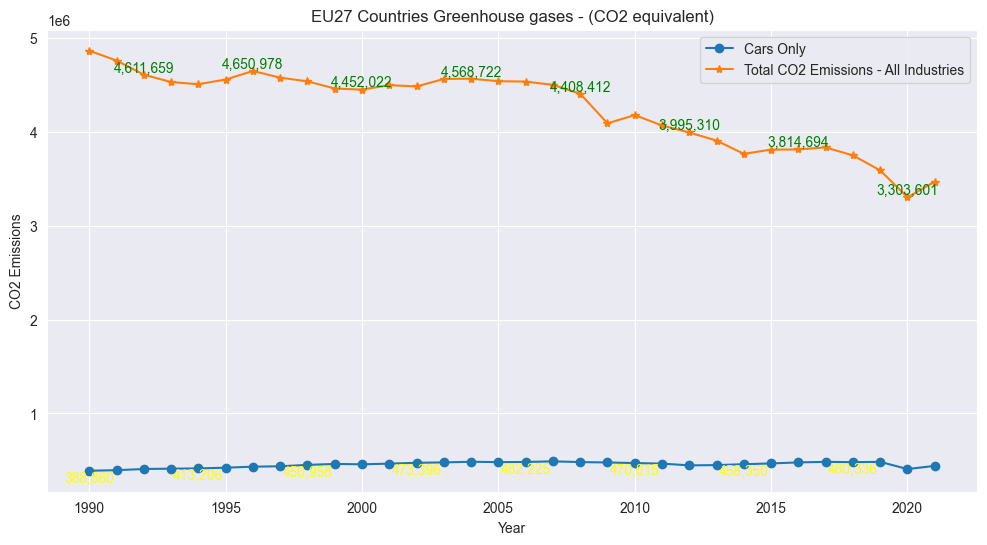

In [437]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(CO2_cars_Only, columns =['Year', 'CarsEmission'])
sorted_df_cars = df.sort_values('Year').reindex()

df1 = pd.DataFrame(CO2_all_sector, columns =['Year', 'AllEmission'])
sorted_df_all = df1.sort_values('Year').reindex()

df_combined = pd.merge(sorted_df_cars, sorted_df_all, on='Year')

plt.figure(figsize=(12, 6))
plt.plot(df_combined['Year'], df_combined['CarsEmission'], label = 'Cars Only', marker='o')
plt.plot(df_combined['Year'], df_combined['AllEmission'], label = 'Total CO2 Emissions - All Industries', marker='*')

n = 4  

for i, (year, CarsEmissionDataPoint) in enumerate(zip(df_combined['Year'], df_combined['CarsEmission'])):
    if i % n == 0:
        plt.text(year, CarsEmissionDataPoint, f'{CarsEmissionDataPoint:,.0f}', ha='center', va='top', color='yellow')

for year, allEmissionDataPoint in zip(df_combined['Year'], df_combined['AllEmission']):
    if year % n == 0:
        plt.text(year, allEmissionDataPoint, f'{allEmissionDataPoint:,.0f}', ha='center', va='bottom', color='green')

plt.title("EU27 Countries Greenhouse gases - (CO2 equivalent)")
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.show()


In [442]:
import psycopg2 
import pandas as pd

readActualAndForecastString = '''select * from EU_CARS_ACTUAL_AND_FORECAST;'''


try :
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(readActualAndForecastString)
    output = dbCursor.fetchall()
    columns = ['Year', 'EVCars', 'EVCarsPercentage', 'AllCars_Total']
    df_EU_CARS_ACTUAL_AND_FORECAST = pd.DataFrame(output, columns=columns)
    #print (df_EU_CARS_ACTUAL_AND_FORECAST)
    df_EU_CARS_ACTUAL_AND_FORECAST.set_index("Year", inplace=True)
    #print (df_EU_CARS_ACTUAL_AND_FORECAST)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


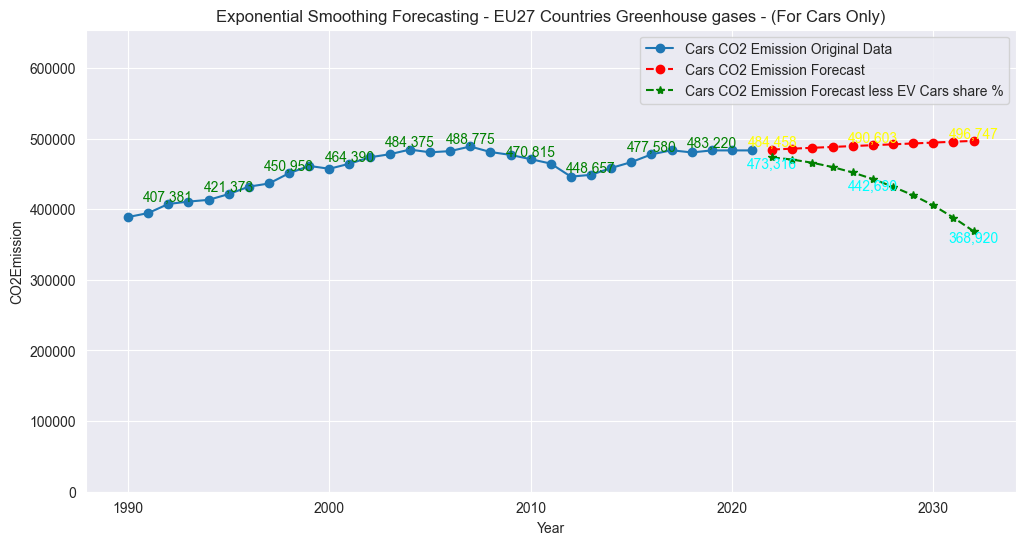

In [471]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

values_for_plot = df_combined['CarsEmission'].values


#2020 and 2021 CO2 emission values are low during Covid hance using 2019 data for forecasting
values_for_forecast = df_combined
#print(values_for_forecast.set_index("Year", inplace=True))
values_for_forecast.loc[2020] = values_for_forecast.loc[2019] 
values_for_forecast.loc[2021] = values_for_forecast.loc[2019] 

# Fit Exponential Smoothing model
model = ExponentialSmoothing(values_for_forecast['CarsEmission'].astype(float),  trend='add', seasonal=None)
fit_model = model.fit()

# Forecasting
forecast_steps = 11
forecast = fit_model.forecast(steps=forecast_steps)

EU_cars_last_forecast_steps =  df_EU_CARS_ACTUAL_AND_FORECAST.iloc[-forecast_steps:]


custom_index = [2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032]
forecast.index = custom_index
EU_cars_last_forecast_steps_pd_series = EU_cars_last_forecast_steps['EVCarsPercentage'].astype(float)

forecast_less_ev_percentage = forecast*(1 - EU_cars_last_forecast_steps_pd_series/100) 

forecast_index = np.arange(df_combined.index.max() +1, df_combined.index.max() + forecast_steps + 1)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index.values,  values_for_plot, label='Cars CO2 Emission Original Data', marker='o')
plt.plot(forecast_index, forecast, label='Cars CO2 Emission Forecast', color='red', linestyle='--', marker='o')
plt.plot(forecast_index, forecast_less_ev_percentage, label='Cars CO2 Emission Forecast less EV Cars share %', color='green', linestyle='--', marker='*')


n = 3  

for year, CarsEmissionDataPoint in zip(df_combined.index.values, values_for_plot):
    if year % n == 0:
        plt.text(year, CarsEmissionDataPoint, f'{CarsEmissionDataPoint:,.0f}', ha='center', va='bottom', color='green')
n=5
for i, (year, ForecastCarsEmissionDataPoint, ForecastCarsEmissionLessEVDataPoint) in enumerate(zip(forecast_index, forecast,forecast_less_ev_percentage)):
    if i % n == 0:
        plt.text(year, ForecastCarsEmissionDataPoint, f'{ForecastCarsEmissionDataPoint:,.0f}', ha='center', va='bottom', color='yellow')
        plt.text(year, ForecastCarsEmissionLessEVDataPoint, f'{ForecastCarsEmissionLessEVDataPoint:,.0f}', ha='center', va='top', color='cyan')

current_ylim = plt.ylim()

new_upper_limit = current_ylim[1] * 1.3 
plt.ylim(bottom=0, top=new_upper_limit)

plt.title('Exponential Smoothing Forecasting - EU27 Countries Greenhouse gases - (For Cars Only)')
#plt.ylim(bottom=0)
plt.xlabel('Year')
plt.ylabel('CO2Emission')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(values_for_plot, fit_model.fittedvalues)
rmse = sqrt(mse)
